In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.models as models

import cv2
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import heapq
import itertools

In [3]:
dir = 'data/'

classes = os.listdir(dir)
num_classes = len(classes)

print(
    f'Number of classes: {num_classes}',
    f'\nClasses: {classes}'
)

Number of classes: 0 
Classes: []


In [3]:
print("--------data--------")
# check the number of images in each class
for cls in classes:
    print(f'{cls}: {len(os.listdir(dir + cls))}')

--------data--------
cloudy: 10000
rain: 10000
shine: 10000
sunrise: 10000


In [4]:
import os
import imghdr
import shutil

def delete_irrelevant_files(directory, classes):
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        with os.scandir(class_dir) as entries:
            for entry in entries:
                # Delete directories
                if entry.is_dir():
                    print(f'Deleting directory: {entry.path}')
                    shutil.rmtree(entry.path)

                # Check if the file is empty and delete it
                elif os.path.getsize(entry.path) == 0:
                    print(f'Deleting empty file: {entry.path}')
                    os.remove(entry.path)

                # Check if the file is not an image and delete it
                elif not imghdr.what(entry.path):
                    print(f'Deleting non-image file: {entry.path}')
                    os.remove(entry.path)

print("--------data--------")
delete_irrelevant_files(dir, classes)

--------data--------


In [5]:
original_dir = 'data_original/'

images = []
for cls in classes:
    img = cv2.imread(dir + cls + '/' + os.listdir(original_dir + cls)[0])
    #img = Image.open(dir + cls + '/' + os.listdir(dir + cls)[0])
    images.append(img)

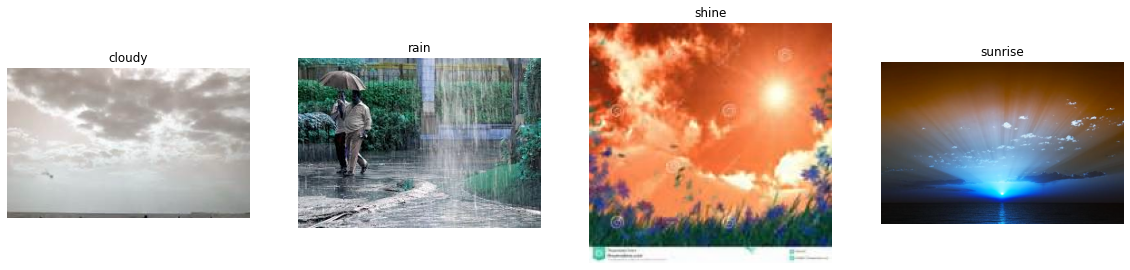

In [6]:
%matplotlib inline

fig, axes = plt.subplots(1, 4, figsize=(20, 20))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(classes[i])
    ax.axis('off')

In [7]:
class WeatherDataset(Dataset):
    def __init__(self, directory, classes, transform=None):
        self.directory = directory
        self.classes = classes
        self.transform = transform
        self.data = []

        for cls in classes:
            class_dir = os.path.join(directory, cls)
            with os.scandir(class_dir) as entries:
                for entry in entries:
                    self.data.append((entry.path, cls))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        label_idx = self.classes.index(label)  # Convert the label to its index
        return image, label_idx


In [8]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load the WeatherDataset
dataset = WeatherDataset(directory=dir, classes=['cloudy', 'rain', 'shine', 'sunrise'], transform=transform)                         
print(f'Test dataset size: {len(dataset)}')

Test dataset size: 40000


In [9]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
class CNNEncoder(nn.Module):
    def __init__(self, input_channels, hidden_dim, num_classes):
        super(CNNEncoder, self).__init__()

        self.input_channels = input_channels
        self.num_classes = num_classes

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_channels + num_classes, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),
        )

        self.fc_mu = nn.Linear(64 * 128 * 128, hidden_dim)
        self.fc_logvar = nn.Linear(64 * 128 * 128, hidden_dim)

    def forward(self, x, labels):
        one_hot_labels = torch.eye(self.num_classes)[labels].to(x.device)
        one_hot_labels = one_hot_labels.view(x.size(0), self.num_classes, 1, 1)
        x = torch.cat([x, one_hot_labels.expand(-1, -1, x.size(2), x.size(3))], dim=1)
        
        x = x.contiguous()
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [11]:
class CNNDecoder(nn.Module):
    def __init__(self, hidden_dim, output_channels, num_classes):
        super(CNNDecoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + num_classes, 64 * 128 * 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64 * 128 * 128),
            nn.Dropout(0.5)
        )

        self.deconv_block1 = nn.Sequential(
            nn.ConvTranspose2d(64, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        self.deconv_block2 = nn.Sequential(
            nn.ConvTranspose2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.deconv_block3 = nn.Sequential(
            nn.ConvTranspose2d(512, output_channels, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, z, labels):
        one_hot_labels = torch.eye(num_classes)[labels].to(z.device)
        z = torch.cat([z, one_hot_labels.view(z.size(0), -1)], dim=1)
        
        z = self.fc(z)
        z = z.view(z.size(0), 64, 128, 128)
        z = self.deconv_block1(z)
        z = self.deconv_block2(z)
        z = self.deconv_block3(z)
        return z

In [12]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_channels, hidden_dim, output_channels, num_classes, z_dim=32):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = CNNEncoder(input_channels, hidden_dim, num_classes)

        self.fc1 = nn.Linear(hidden_dim, z_dim)
        self.fc2 = nn.Linear(hidden_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, hidden_dim)

        self.decoder = CNNDecoder(hidden_dim, output_channels, num_classes)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        esp = esp.to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [ ]:
model = VariationalAutoencoder(
    input_channels=3,
    hidden_dim=1024,
    output_channels=3,
    num_classes=4,
    z_dim=32
)

model = model.to(device)


In [13]:
import torch.optim as optim
import torch.nn.functional as F

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Train dataset size: 32000
Test dataset size: 8000


In [14]:
def kl_divergence_loss(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def reconstruction_loss(recon_x, x):
    return F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')

def criterion(recon_x, x, mu, logvar):
    kl_loss = kl_divergence_loss(mu, logvar)
    recon_loss = reconstruction_loss(recon_x, x)
    return recon_loss + kl_loss

In [22]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)  # Move labels to the device
        optimizer.zero_grad()
        with autocast():
            recon_batch, mu, logvar = model(data, labels)
            loss = criterion(recon_batch, data, mu, logvar)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
    return train_loss / len(train_loader.dataset)


In [23]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            data = data.to(device)
            labels = labels.to(device)
            with autocast():
                recon_batch, mu, logvar = model(data, labels)
                test_loss += criterion(recon_batch, data, mu, logvar).item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader.dataset)))
    return test_loss / len(test_loader.dataset)

In [25]:
num_classes = 4  # Set the number of classes based on your dataset
model = VariationalAutoencoder(input_channels=3, hidden_dim=20, output_channels=3, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001)

In [26]:
from torch.cuda.amp import GradScaler, autocast

In [27]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [28]:
num_epochs = 100

train_loss_list = []
val_loss_list = []
# Training loop
for epoch in range(1, num_epochs + 1):
    
    train_loss = train(model, train_loader, optimizer, epoch)
    train_loss_list.append(train_loss)
    
    val_loss = test(model, test_loader)
    val_loss_list.append(val_loss)
    
    scheduler.step(val_loss)

RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

In [ ]:
import pandas as pd
import seaborn as sns

# Convert the lists to DataFrames
train_loss_list = pd.DataFrame({'Epoch': range(len(train_loss_list)), 'Loss': train_loss_list, 'Type': 'Train'})

# Plot the graph
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
sns.lineplot(data=train_loss_list, x='Epoch', y='Loss', hue='Type')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the graph to a file
plt.savefig('loss_graph_Adam.png', dpi=300)

plt.show()

In [ ]:
# define a function to check pytorch version
def check_pytorch_version():
    if torch.__version__ >= '1.6.0':
        return True
    else:
        return False
    
# define a function to check cuda version
def check_cuda_version():
    if torch.cuda.is_available():
        return True
    else:
        return False
    
# define a function to check cudnn version
def check_cudnn_version():
    if check_cuda_version():
        if torch.backends.cudnn.enabled:
            return True
        else:
            return False
    else:
        return False
    
# define a function to check if the system is ready for training
def check_system():
    if check_pytorch_version():
        print('PyTorch version: {}'.format(torch.__version__))
    else:
        print('PyTorch version: {} (update required)'.format(torch.__version__))
        
    if check_cuda_version():
        print('CUDA version: {}'.format(torch.version.cuda))
    else:
        print('CUDA version: {} (install CUDA to enable GPU training)'.format(torch.version.cuda))
        
    if check_cudnn_version():
        print('cuDNN version: {}'.format(torch.backends.cudnn.version()))
    else:
        print('cuDNN version: {} (install cuDNN to enable GPU training)'.format(torch.backends.cudnn.version()))

check_system()

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip install cumm-cu118